# Data Preparation (Checking for NaNs and duplicates)

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, max_error, mean_absolute_percentage_error

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, OrdinalEncoder, MinMaxScaler
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.linear_model import Lasso


train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

train = train.drop_duplicates()

train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [49]:
X = train.drop(columns='SalePrice')
y = train.SalePrice

for col in X.select_dtypes(include=np.number).columns:
    X[col] = pd.to_numeric(X[col],errors='coerce')

In [50]:
nullcnt = X.isnull().sum()

nullcnt = nullcnt[nullcnt>0].apply(lambda x: x/data.shape[0]).sort_values(ascending=False)

null_col = nullcnt.index

nullcnt

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
BsmtExposure    0.026027
BsmtFinType2    0.026027
BsmtFinType1    0.025342
BsmtCond        0.025342
BsmtQual        0.025342
MasVnrArea      0.005479
MasVnrType      0.005479
Electrical      0.000685
dtype: float64

In [51]:
X = X.drop(columns=null_col[:6])

X = X.drop(columns='Id')

In [52]:
X[X.select_dtypes(exclude=np.number).columns].apply(lambda x: x.unique()) 

MSZoning                                 [RL, RM, C (all), FV, RH]
Street                                                [Pave, Grvl]
LotShape                                      [Reg, IR1, IR2, IR3]
LandContour                                   [Lvl, Bnk, Low, HLS]
Utilities                                         [AllPub, NoSeWa]
LotConfig                      [Inside, FR2, Corner, CulDSac, FR3]
LandSlope                                          [Gtl, Mod, Sev]
Neighborhood     [CollgCr, Veenker, Crawfor, NoRidge, Mitchel, ...
Condition1       [Norm, Feedr, PosN, Artery, RRAe, RRNn, RRAn, ...
Condition2       [Norm, Artery, RRNn, Feedr, PosN, PosA, RRAn, ...
BldgType                     [1Fam, 2fmCon, Duplex, TwnhsE, Twnhs]
HouseStyle       [2Story, 1Story, 1.5Fin, 1.5Unf, SFoyer, SLvl,...
RoofStyle               [Gable, Hip, Gambrel, Mansard, Flat, Shed]
RoofMatl         [CompShg, WdShngl, Metal, WdShake, Membran, Ta...
Exterior1st      [VinylSd, MetalSd, Wd Sdng, HdBoard, BrkFace,

In [53]:
Xin_col = X.columns

X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.3,random_state=5)

# Imputation

In [54]:
catdf = X_train.select_dtypes(exclude=np.number)
numdf = X_train.select_dtypes(include=np.number)


imp_pipe = ColumnTransformer([
    ('catimp', SimpleImputer(strategy='most_frequent'), catdf.columns),
    ('numimp', SimpleImputer(strategy='median'), numdf.columns)
])

X_train = imp_pipe.fit_transform(X_train)

imp_colname = imp_pipe.transformers_[0][1].get_feature_names_out().tolist()\
            + imp_pipe.transformers_[1][1].get_feature_names_out().tolist()



X_train = pd.DataFrame(X_train,columns=imp_colname).astype({col:'float64' for col in numdf.columns})

X_val = pd.DataFrame(imp_pipe.transform(X_val),columns=imp_colname).astype({col:'float64' for col in numdf.columns})

# Numerical Data

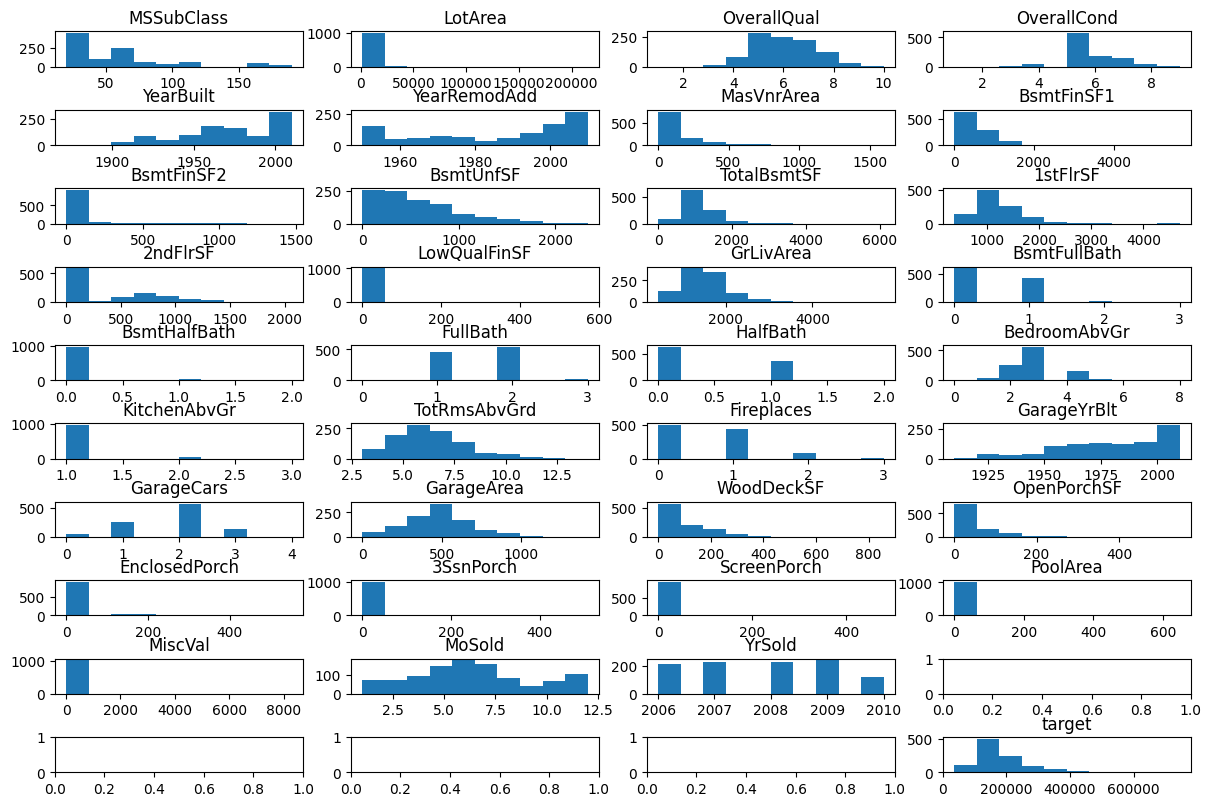

In [55]:
fig,ax = plt.subplots(10,4,figsize=(12,8))
ax = ax.flatten()
fig.tight_layout(w_pad=1, h_pad=1)

for ind,col in enumerate(X_train.select_dtypes(include=np.number)):
    ax[ind].hist(X_train[col])
    ax[ind].set_title(col)

ax[-1].hist(y_train)
ax[-1].set_title('target')
    
plt.show()

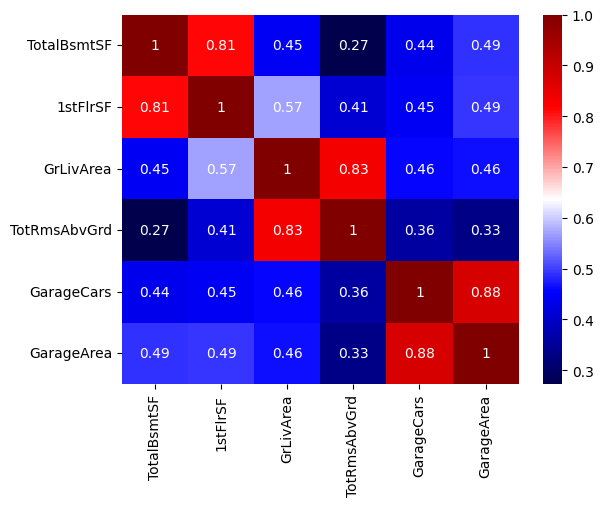

In [56]:
corrdf = X_train.select_dtypes(include=np.number).corr().abs()

high_corr_col = corrdf[corrdf.applymap(lambda x: True if (x>=0.8) and (x<1) else False).sum() > 0].index
corrdf_small = corrdf.loc[high_corr_col,high_corr_col]

sns.heatmap(corrdf_small,annot=corrdf_small,cmap='seismic')

plt.show()

# Categorical Data

In [57]:
ord_ccol = catdf[['Street','LotShape', 'LandContour','Utilities', 
                  'LandSlope','ExterQual', 'ExterCond', 'BsmtQual', 
                  'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                  'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 
                  'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive']].columns
nom_ccol = catdf.drop(columns=ord_ccol).columns


ord_cat_dict = {'Street':['NA','Grvl','Pave'],
                'LotShape':['IR3','IR2','IR1','Reg'], 
                'LandContour':['Lvl','Bnk','HLS','Low'], 
                'Utilities':['ELO','NoSeWa','NoSewr','AllPub'], 
                'LandSlope':['Sev','Mod','Gtl'], 
                'ExterQual':['Po','Fa','TA','Gd','Ex'], 
                'ExterCond':['Po','Fa','TA','Gd','Ex'], 
                'BsmtQual':['NA','Po','Fa','TA','Gd','Ex'], 
                'BsmtCond':['NA','Po','Fa','TA','Gd','Ex'], 
                'BsmtExposure':['NA','No','Mn','Av','Gd'], 
                'BsmtFinType1':['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ'], 
                'BsmtFinType2':['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ'], 
                'HeatingQC':['Po','Fa','TA','Gd','Ex'], 
                'CentralAir':['N','Y'], 
                'KitchenQual':['Po','Fa','TA','Gd','Ex'], 
                'Functional':['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ'], 
                'GarageFinish':['NA','Unf','RFn','Fin'], 
                'GarageQual':['NA','Po','Fa','TA','Gd','Ex'], 
                'GarageCond':['NA','Po','Fa','TA','Gd','Ex'], 
                'PavedDrive':['N','P','Y']}



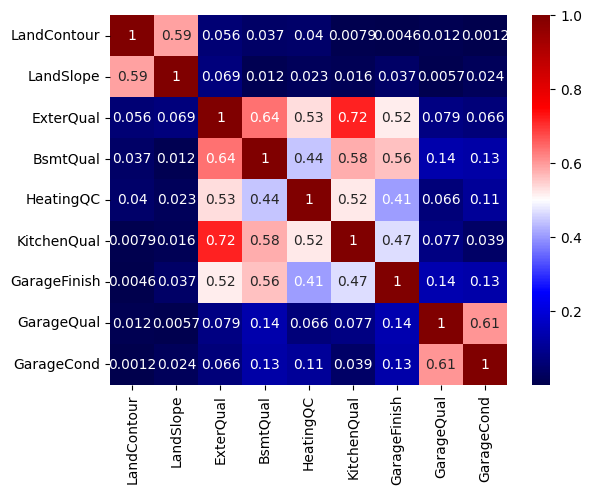

In [58]:
orde = OrdinalEncoder(categories=[ord_cat_dict[cat] for cat in ord_cat_dict])

ordcol_arr = orde.fit_transform(X_train[ord_ccol])
ordcol_df = pd.DataFrame(ordcol_arr, columns=X_train[ord_ccol].columns)

cat_corrdf = ordcol_df.corr().abs()

high_corr_catcol = cat_corrdf[cat_corrdf.applymap(lambda x: True if (x>=0.5) and (x<1) else False).sum() > 0].index
cat_corrdf_small = cat_corrdf.loc[high_corr_catcol,high_corr_catcol]

sns.heatmap(cat_corrdf_small,annot=cat_corrdf_small,cmap='seismic')

plt.show()

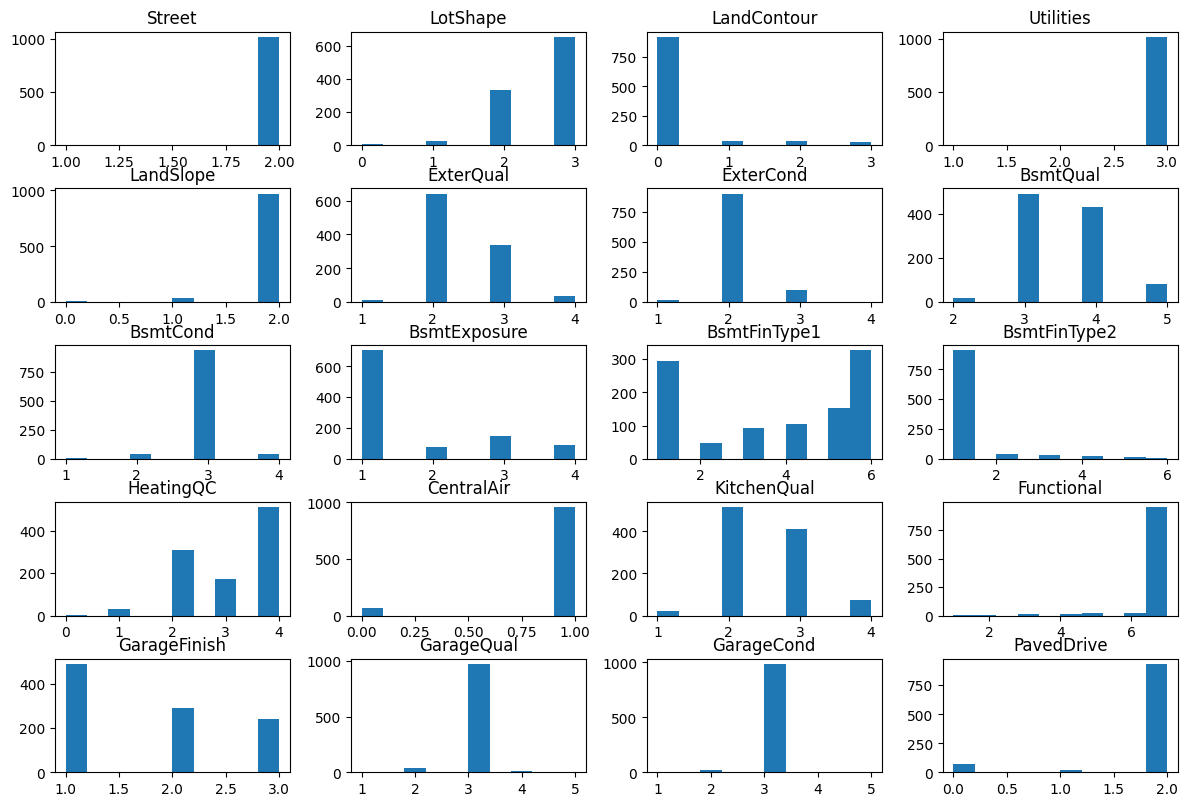

In [59]:
fig2,ax2 = plt.subplots(5,4,figsize=(12,8))
ax2 = ax2.flatten()
fig2.tight_layout(w_pad=1, h_pad=1)

for ind,col in enumerate(ordcol_df):
    ax2[ind].hist(ordcol_df[col])
    ax2[ind].set_title(col)
    
plt.show()

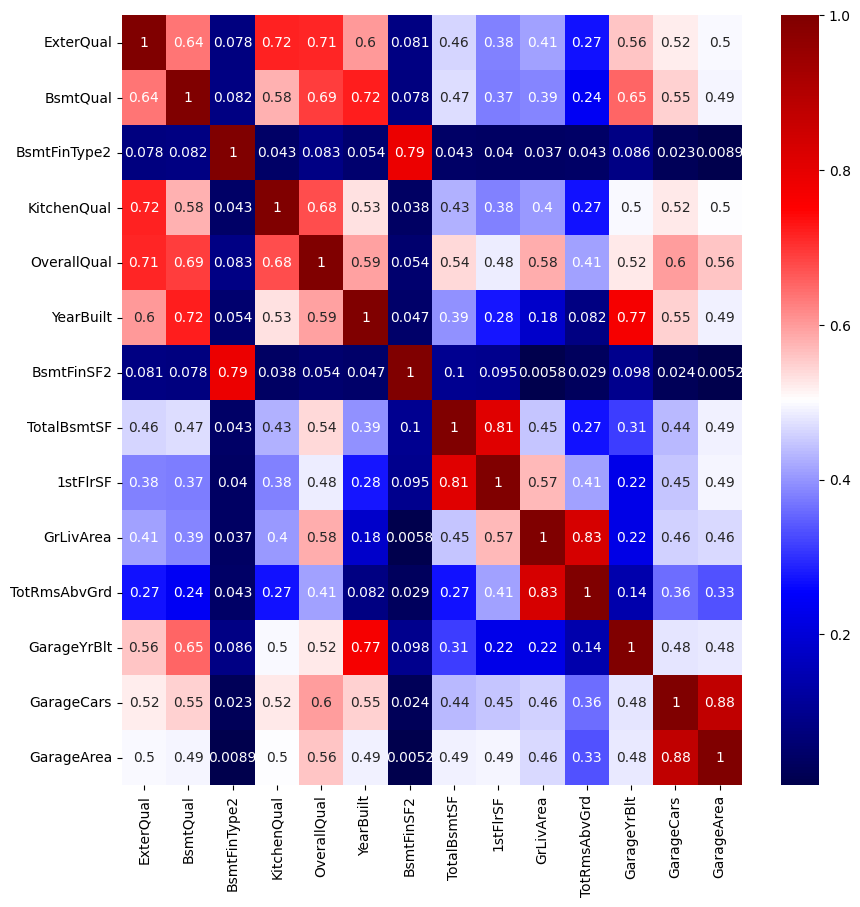

In [60]:
X_corrdf = pd.concat([ordcol_df, X_train[numdf.columns]], axis=1).corr().abs()

high_corr_Xcol = X_corrdf[X_corrdf.applymap(lambda x: True if (x>=0.7) and (x<1) else False).sum() > 0].index
X_corrdf_small = X_corrdf.loc[high_corr_Xcol,high_corr_Xcol]


figcorr, axcorr = plt.subplots(figsize=(10,10))  
sns.heatmap(X_corrdf_small,annot=X_corrdf_small,cmap='seismic')

plt.show()

# Preprocessing

In [61]:
#nomenc = OneHotEncoder(sparse=False, handle_unknown='ignore')
#ordenc = OrdinalEncoder()

#nom_encoded = nomenc.fit_transform(X_train[nom_ccol])

#cat_arr = []
#for arr in nomenc.categories_:
    #cat_arr.extend(arr)
    
#X_train[cat_arr] = nom_encoded
    
#X_train[ord_ccol] = ordenc.fit_transform(X_train[ord_ccol])

In [62]:
cat_enc_pipe = ColumnTransformer([
    ('nomenc', OneHotEncoder(sparse=False, handle_unknown='ignore'), nom_ccol),
    ('ordenc', OrdinalEncoder(categories=[ord_cat_dict[cat] for cat in ord_cat_dict]), ord_ccol)
])

cat_pipe = Pipeline([
    ('catpipe', cat_enc_pipe),
    ('catsclr', MinMaxScaler())
])

preproc_pipe = ColumnTransformer([
    ('numsclr', RobustScaler(), numdf.columns),
    ('catpipe', cat_pipe, catdf.columns)
])


preproc_pipe

ColumnTransformer(transformers=[('numsclr', RobustScaler(),
                                 Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvG...
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object'))])

In [63]:
X_train = preproc_pipe.fit_transform(X_train)

X_cols = preproc_pipe.transformers_[0][1].get_feature_names_out().tolist()\
        + preproc_pipe.transformers_[1][1].get_feature_names_out().tolist()

X_train = pd.DataFrame(X_train,columns=X_cols)

X_val = pd.DataFrame(preproc_pipe.transform(X_val),columns=X_cols)

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [64]:
X_train

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,ordenc__BsmtFinType1,ordenc__BsmtFinType2,ordenc__HeatingQC,ordenc__CentralAir,ordenc__KitchenQual,ordenc__Functional,ordenc__GarageFinish,ordenc__GarageQual,ordenc__GarageCond,ordenc__PavedDrive
0,0.2,0.103638,0.5,0.0,0.687500,0.324324,0.000000,-0.001404,0.0,-0.013799,...,1.0,0.0,0.75,1.0,0.666667,1.000000,0.5,0.5,0.50,1.0
1,0.0,-0.071899,-0.5,1.0,-0.645833,-1.162162,0.000000,-0.231742,380.0,-0.817594,...,0.2,0.4,0.50,0.0,0.333333,1.000000,0.0,0.5,0.25,1.0
2,-0.6,-0.638794,0.5,0.0,0.729167,0.378378,0.635294,0.369382,0.0,0.120742,...,1.0,0.0,1.00,1.0,0.666667,1.000000,0.5,0.5,0.50,1.0
3,0.7,0.669800,0.5,4.0,-0.229167,0.378378,1.235294,0.654494,0.0,-0.684778,...,0.8,0.0,0.75,1.0,1.000000,1.000000,0.5,0.5,0.50,1.0
4,2.8,0.347046,-0.5,-1.0,-1.500000,-0.621622,0.000000,0.369382,0.0,-0.317378,...,0.6,0.0,0.50,0.0,0.333333,0.500000,0.0,0.5,0.25,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,-0.6,0.030396,-0.5,0.0,-0.291667,-0.270270,0.000000,0.078652,374.0,-0.484692,...,0.8,0.4,0.50,1.0,0.333333,0.833333,0.0,0.5,0.50,1.0
1018,0.2,0.143188,1.0,0.0,0.708333,0.378378,2.000000,1.051966,0.0,-0.272531,...,1.0,0.0,1.00,1.0,0.666667,1.000000,0.5,0.5,0.50,1.0
1019,-0.4,0.099487,-1.5,-1.0,-1.041667,-1.162162,0.000000,-0.563202,0.0,0.919362,...,0.0,0.0,0.25,0.0,0.333333,1.000000,0.0,0.5,0.25,0.5
1020,-0.6,1.048462,-0.5,0.0,-0.208333,-0.837838,0.000000,-0.563202,0.0,1.148771,...,0.0,0.0,0.50,1.0,0.333333,0.666667,0.5,0.5,0.50,1.0


# Model

In [65]:
base_model = Lasso(max_iter=10000)

base_model.fit(X_train,y_train)

cross_validate(base_model,X_train,y_train,cv=5,scoring=['neg_mean_absolute_percentage_error','max_error','r2'])

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.611e+11, tolerance: 6.720e+08
  model = cd_fast.enet_coordinate_descent(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.224e+11, tolerance: 5.588e+08
  model = cd_fast.enet_coordinate_descent(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider

{'fit_time': array([0.98454213, 1.10361981, 1.19667006, 0.94307995, 1.04842973]),
 'score_time': array([0.00384474, 0.01260352, 0.00377941, 0.01306653, 0.00396442]),
 'test_neg_mean_absolute_percentage_error': array([-0.13500401, -0.13438936, -0.10816853, -0.12108197, -0.12243754]),
 'test_max_error': array([-624133.41436729, -156412.70520969, -103580.93129038,
        -273446.93263497, -155537.98122457]),
 'test_r2': array([0.51337875, 0.86909807, 0.91037371, 0.83920083, 0.85331089])}

In [66]:
coefdf = pd.DataFrame(base_model.coef_, index=X_train.columns).abs().sort_values(by=0,ascending=False)

impt_col = coefdf[coefdf[0] > 0].index

In [67]:
base_model.fit(X_train[impt_col],y_train)

cross_validate(base_model,X_train[impt_col],y_train,cv=5,scoring=['neg_mean_absolute_percentage_error','max_error','r2'])

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.643e+10, tolerance: 6.720e+08
  model = cd_fast.enet_coordinate_descent(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.626e+10, tolerance: 5.588e+08
  model = cd_fast.enet_coordinate_descent(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider

{'fit_time': array([1.06764984, 1.38679767, 1.22253346, 1.0665307 , 1.20900583]),
 'score_time': array([0.01297331, 0.01285291, 0.01281905, 0.01284361, 0.01392007]),
 'test_neg_mean_absolute_percentage_error': array([-0.13473934, -0.13390276, -0.10812616, -0.12037929, -0.12034068]),
 'test_max_error': array([-623605.36035572, -156409.39473696, -103464.64688542,
        -272148.05170331, -155741.52936779]),
 'test_r2': array([0.51481786, 0.86973304, 0.91031654, 0.84036352, 0.85529565])}

In [68]:
permutation_score = permutation_importance(base_model, X_train[impt_col], y_train, n_repeats=10)

importance_df = pd.DataFrame(np.vstack((X_train[impt_col].columns, permutation_score.importances_mean)).T)
importance_df.columns=['feature','score decrease']

importance_df = importance_df.sort_values(by="score decrease", ascending = False)

importance_df.loc[importance_df['score decrease'] > 0.0001]

,feature,score decrease
39,GrLivArea,0.175723
0,nomenc__RoofMatl_ClyTile,0.116645
4,nomenc__SaleType_New,0.04897
38,OverallQual,0.0384
45,BsmtFinSF1,0.02676
...,...,...
178,3SsnPorch,0.000134
133,nomenc__Foundation_BrkTil,0.000128
69,nomenc__Condition1_PosA,0.000124
44,nomenc__Condition2_RRNn,0.000114


In [69]:
optcol = importance_df.loc[importance_df['score decrease'] > 0.001].feature
base_model.fit(X_train[optcol],y_train)

cross_validate(base_model,X_train[optcol],y_train,scoring=['neg_mean_absolute_percentage_error','max_error','r2'],cv=5)

{'fit_time': array([0.02814198, 0.07907891, 0.05320477, 0.06607628, 0.05327034]),
 'score_time': array([0.01132298, 0.00442767, 0.00402761, 0.00457811, 0.00404215]),
 'test_neg_mean_absolute_percentage_error': array([-0.1173156 , -0.12579787, -0.09299997, -0.11080206, -0.106318  ]),
 'test_max_error': array([-597062.10935988, -129812.17392286, -106521.69718374,
        -251392.43633668, -155363.87102902]),
 'test_r2': array([0.56863235, 0.89572611, 0.92979911, 0.8625708 , 0.87447184])}

# Final Test

In [70]:
val_pred = base_model.predict(X_val[optcol])

print(f'r2: {r2_score(y_val,val_pred)}')
print(f'max error: {max_error(y_val,val_pred)}')
print(f'mean abs percent error: {mean_absolute_percentage_error(y_val,val_pred)}')

r2: 0.8150915443969544
max error: 402827.190289182
mean abs percent error: 0.1153347980803208


# Real Prediciton

In [80]:
test = test[Xin_col]
test = pd.DataFrame(imp_pipe.transform(test),columns=imp_colname).astype({col:'float64' for col in numdf.columns})
test = pd.DataFrame(preproc_pipe.transform(test),columns=X_cols)
pred = pd.DataFrame({"Id":np.arange(1461,2920), "SalePrice":base_model.predict(test[optcol])})

In [82]:
with open('data/predictions.csv','w') as file:
    file.write(pred.to_csv(index=False))